In [1]:
from google.cloud import bigquery
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
client = bigquery.Client()

/home/thorad/.conda/envs/axiom/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/thorad/.conda/envs/axiom/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.

In [4]:
from datetime import timedelta  

In [5]:
asset_num = 50;

In [6]:
def get_first_timestamp():
    query_job = client.query("""SELECT Min(close_timestamp_ms) AS first_timestamp
FROM Binance_1m_BTC_klines.Binance_1m_BTC_1500005000_1548440000;""")
    first_timestamp = query_job.result()
    for row in first_timestamp:
        return row.first_timestamp

In [7]:
def get_last_timestamp():
    query_job = client.query("""SELECT Max(close_timestamp_ms) AS last_timestamp
FROM Binance_1m_BTC_klines.Binance_1m_BTC_1500005000_1548440000;""")
    last_timestamp = query_job.result()
    for row in last_timestamp:
        return row.last_timestamp

In [8]:
# todo minus day on last timestamp plus day on first timestamp

In [9]:
def get_top_assets_for_period(asset_num, start_time, end_time):
    top_symbols = []
    query_job = client.query("""
    SELECT base_asset, SUM(CAST(quote_asset_volume AS FLOAT64)) AS total_volume 
    FROM Binance_1m_BTC_klines.Binance_1m_BTC_1500005000_1548440000
    WHERE close_timestamp_ms>=1548346400000 and close_timestamp_ms<=1548440000000
    GROUP BY base_asset ORDER BY total_volume DESC LIMIT 50""")
    top_assets = query_job.result()
    for row in top_assets:
#         print("{} : {}".format(row.base_asset, row.total_volume))
        top_symbols.append(row.base_asset)
    return top_symbols;

In [10]:
# top_symbols = get_top_assets_for_period()

In [11]:
first_timestamp = get_first_timestamp()

In [12]:
last_timestamp = get_last_timestamp()

In [13]:
timestamp_range = last_timestamp - first_timestamp

In [14]:
first_timestamp = first_timestamp + (60000*1440)

In [15]:
end_timestamp = first_timestamp + (60000*1440)

In [16]:
last_timestamp = last_timestamp - (60000*1440)

In [17]:
start_timestamp = last_timestamp - (60000*100)

In [18]:
last_timestamp

1548353519999

In [19]:
start_timestamp

1548347519999

In [20]:
# todo round timestamp_ms

In [21]:
def get_features(start_time, end_time, selection_start_time, selection_end_time):
    query = """
    SELECT
    base_asset,
    timestamp_ms,
    CAST(close AS FLOAT64) AS c,
    CAST(open AS FLOAT64) AS o,
    CAST(low AS FLOAT64) AS l,
    CAST(high AS FLOAT64) AS h,
    CAST(quote_asset_volume AS FLOAT64) AS v,
    CAST(trades AS FLOAT64) AS t
    FROM Binance_1m_BTC_klines.Binance_1m_BTC_1500005000_1548440000
    WHERE base_asset IN (
        SELECT base_asset
        FROM Binance_1m_BTC_klines.Binance_1m_BTC_1500005000_1548440000
        WHERE close_timestamp_ms>={sts} AND close_timestamp_ms<={ets}
        GROUP BY base_asset ORDER BY SUM(CAST(quote_asset_volume AS FLOAT64)) DESC LIMIT 50
    )
    AND timestamp_ms>={st}
    AND timestamp_ms<={et}+1
    ORDER BY timestamp_ms;
    """.format(st=start_time, et=end_time, sts=selection_start_time, ets=selection_end_time)
    query_job = client.query(query)
    features = query_job.to_dataframe()
    return features

In [22]:
features = get_features(start_timestamp, last_timestamp, start_timestamp, last_timestamp)

In [23]:
x = features.copy()
x.set_index(['base_asset', 'timestamp_ms'], inplace=True)

In [24]:
t_index = list(range(int(start_timestamp/1000), int(last_timestamp/1000), 60))
time_index = pd.to_datetime(t_index,unit='s')
time_index = time_index.round('min');

In [25]:
y = features.copy()

In [26]:
y['timestamp_ms'] = pd.to_datetime(y['timestamp_ms'], unit='ms')
y.set_index(['base_asset', 'timestamp_ms'], inplace=True)
y=y.groupby(['base_asset','timestamp_ms']).first()
ind = pd.MultiIndex.from_product([y.index.levels[0], time_index], names=y.index.names)
y = y.reindex(ind)
y = y.fillna(axis=1, method="bfill").fillna(axis=1, method="ffill")

In [34]:
arr = y.to_xarray().to_array()

In [35]:
arr.shape

(6, 50, 100)

In [27]:
bnx = [{'asset':asset, 'std':y.loc[asset].std()['c']*y['c'].sum()} for asset in y.index.levels[0]]

In [28]:
ob = [{'asset':asset, 'std':y.loc[asset].std()['c']} for asset in y.index.levels[0]]

In [29]:
from operator import itemgetter

In [30]:
newlist = sorted(bnx, key=itemgetter('std'))
newob = sorted(ob, key=itemgetter('std')) 

In [31]:
pd.DataFrame(newlist).transpose()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
asset,DENT,MFT,NPXS,HOT,RVN,ZIL,TRX,DOCK,GO,POE,...,WAVES,LUN,GVT,LTC,XMR,BCHSV,ETH,DASH,BCHABC,ZEC
std,5.99629e-08,7.85662e-08,9.04149e-08,1.05304e-07,1.16062e-07,1.3588e-07,1.72807e-07,1.80857e-07,1.86921e-07,1.94707e-07,...,5.98033e-05,0.000102426,0.000128126,0.000253598,0.000261808,0.000295476,0.000467355,0.000536793,0.000864097,0.000950899


In [72]:
pd.DataFrame(newob).transpose()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
asset,NPXS,XVG,VET,HOT,IOST,PHX,FUN,QKC,ZIL,DOCK,...,ZEC,GVT,LUN,LTC,XMR,BCHSV,ETH,REP,DASH,BCHABC
std,7.89943e-09,2.82057e-08,2.85009e-08,3.08085e-08,3.09826e-08,5.0314e-08,8.82008e-08,1.04329e-07,1.20001e-07,1.20346e-07,...,8.8748e-05,9.12049e-05,9.30589e-05,9.31217e-05,0.000106299,0.00012937,0.000170713,0.000247509,0.000282793,0.000973695


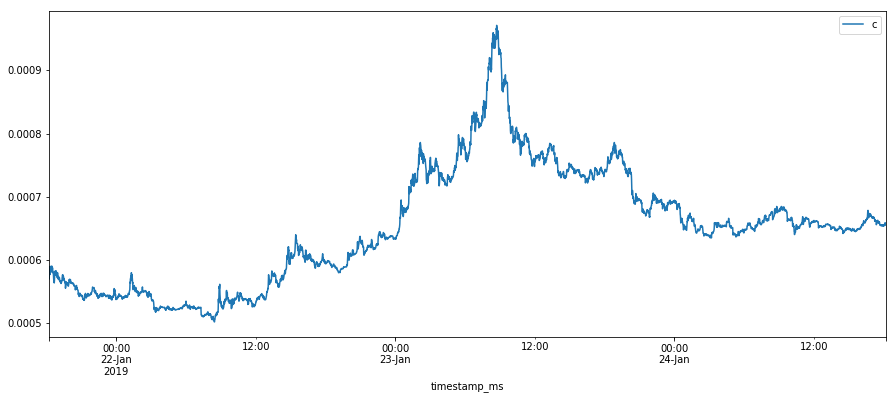

In [96]:
y.loc['LUN'][['c']].plot(figsize=(15, 6), subplots=False, layout=(2, 1));

In [ ]:
# portfolio vector memory, [time, assets]
PVM = pd.DataFrame(
    index=y.index.levels[1],
    columns=y.index.levels[0]
)

In [ ]:
PVM = PVM.fillna(1.0 / len(y.index.levels[0]))